# # The BBC News Glove(TF) vs Bert(TF-Pytorch) 

* The dataset includes 2225 News and all are labeled.
* There are 5 different label categories for these news.
* This dataset is very clean in terms of nlp because it is written by bbc editors. 
* Three different Neural Networks will be used to predict labels.
* I have created BERT with two different libraries to see different. I also more familiar with Tensorflow, so it helps to understand how Pytorch works.

*1) Glove Embeddings*
* Glove provides vector representation for words. I will use Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors).
* It basically provides 300 dimensinal vector. Every dimension represents different feature of word. For example, one is positivity value one is negativity and so on.
* This helps to create emmbedding matrix for Neural Network input.
* The bidirectional layer will be used in neural network. Bidirectional layer is impoartant to train nlp dataset because it trains the sentence or text as is and reversed of sentence.
* For example, "I like a bar that plays jazz music" - "I like a bar of white chocolate not small piece". As you can see first 3 words are same. If we don't train with bidirectional layers, we cannot understand real meaning of the bar.

*2) BERT*
* BERT stands for Bidirectional Encoder Representation from Transformers
* It is pretrained model and as you can see from its name, it pre-trained deep bidirectional with own embedding matrix.
* Bert has hidden state that has 768 dimensions that is similar to embedding matrix.
* BERT-Base-Uncased: 12-layers, 768-hidden_size, 12-heads, 110M parameters.
* The max number of tokens is 512 for BERT.


*References*
* https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert/output#0.-Introduction-and-References
* https://www.kaggle.com/shoheiazuma/tweet-sentiment-roberta-pytorch
* https://www.kaggle.com/abhishek/bert-base-uncased-using-pytorch
* http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/    (Pictures)

* I have inspired from these notebooks. Please upvote them, as well.

# Import Libraries

In [1]:
import os
import math
import pandas as pd
import numpy as np
import tensorflow as tf
import itertools
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable = True , offline = False)


from transformers import AdamW
import transformers

from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

from tqdm import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amakr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\amakr\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# stopw
df = pd.read_csv('../Translated/cleaned/train.csv')
df_test_2 = pd.read_csv('../Translated/cleaned/test.csv')

# df
# train
# all_text

# Impporting Dataset
* Importing the dataset and found all class names.
* The labels are encoded with one hot encoding. 

In [3]:
# df_test_2
all_text = pd.concat([df['Text'],df_test_2['Text']], ignore_index = True)
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Every dataset is lower cased except for TREC
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)     
    string = re.sub(r",", " ", string) 
    string = re.sub(r"!", " ", string) 
    string = re.sub(r"\(", " ", string) 
    string = re.sub(r"\)", " ", string) 
    string = re.sub(r"\?", " ", string) 
    string = re.sub(r"\s{2,}", " ", string)   
    string = re.sub(" \d+", " ", string)
    return  string.strip().lower()
df["Text"] =df.Text.apply(lambda x: clean_str(x))
all_text = all_text.apply(lambda x: clean_str(x))

In [4]:
from collections import Counter 
counter = Counter(" ".join(all_text).split())
# all_text


In [5]:
# all_text.shape
# stopw = stopw +L
# stopw

In [6]:
# counter.most_common(10)
# 'ndi' in stopw


In [7]:
df_freq = pd.DataFrame(counter.most_common(), columns =['word', 'freq'])

In [8]:
df_freq

,word,freq
0,ndi,20347
1,kuti,14102
2,wa,9924
3,a,7463
4,ya,7104
...,...,...
63466,adangogamula,1
63467,atafunsira,1
63468,atsogeri,1
63469,omuyenereza,1


In [9]:
# import re
# L =[]
# for wo in tqdm(df_freq.word):
#     ids = (df["Text"].str.contains(' '+wo+' ', flags = re.IGNORECASE, regex = True, na = False))
#     if df.Label[ids].unique().shape[0]>19:
#         L.append(wo)
 

In [10]:
# import re
# L2 =[]
# for wo in tqdm(df_freq.word):
#     ids = (df["Text"].str.contains(' '+wo+' ', flags = re.IGNORECASE, regex = True, na = False))
#     if df.Label[ids].unique().shape[0]>5:
#         L2.append(wo)

In [11]:
# len(L2)
# pd.DataFrame(L2).to_csv('words_shared_by_more_than_6.csv', index = False)
# L = pd.read_csv('words_shared_by_all.csv')
# L.values.tol_list()
other_stop_w = pd.read_csv('words_shared_by_all.csv')
stopw = [item for sublist in other_stop_w.values.tolist() for item in sublist]


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words = stopw)
X = vectorizer.fit_transform(all_text)

In [13]:
print(vectorizer.get_stop_words())


frozenset({'ati', 'ina', 'bwanji', 'ali', 'kwa', 'zawo', 'dziko', 'lawo', 'kukhala', 'anthu', 'zambiri', 'nthawi', 'malo', 'cha', 'ndipo', 'zomwe', 'kwambiri', 'bwino', 'mboma', 'yemwe', 'chino', 'zina', 'kuti', 'adali', 'ena', 'pomwe', 'komwe', 'ayamba', 'akuti', 'lilongwe', 'nawo', 'limodzi', 'chifukwa', 'yomwe', 'wake', 'mwa', 'masiku', 'zili', 'ngati', 'a', 'koma', 'pali', 'ku', 'malinga', 'chake', 'ya', 'malamulo', 'ndiye', 'omwe', 'ntchito', 'iye', 'kupita', 'mu', 'nkhani', 't', 'awo', 'pa', 'nyumba', 'momwe', 'wa', 'mdziko', 'chomwe', 'chaka', 'tsiku', 'lomwe', 'kapena', 'monga', 'palibe', 'ndi', 'amene', 'ndalama', 'za', 'komanso', 'pamene', 'izi', 'moyo', 'zinthu', 'la', 'muno', 'ife'})


In [14]:
# df = pd.read_csv('../Translated/cleaned/train.csv')
# df_test_2 = pd.read_csv('../Translated/cleaned/test.csv')
# df_test_2['Label'] = 'POLITICS'
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
df['label'] = enc.fit_transform(df['Label'])
# df_test_2['label'] = enc.transform(df_test_2['Label'])
class_names = df.groupby(['Label', 'label']).count().reset_index().loc[:,['Label', 'label']]
class_name_tokenizers = {}
for class_name in class_names.Label:
    class_name_tokenizers[class_name] = [tokenizer.encode(class_name)[1],class_names[class_names['Label'] == class_name]['label'].iloc[0]]

In [15]:
#Class names are encoded one hot encoding method and encoded with Bert tokenizer.
# class_name_tokenizers
# df_test_2

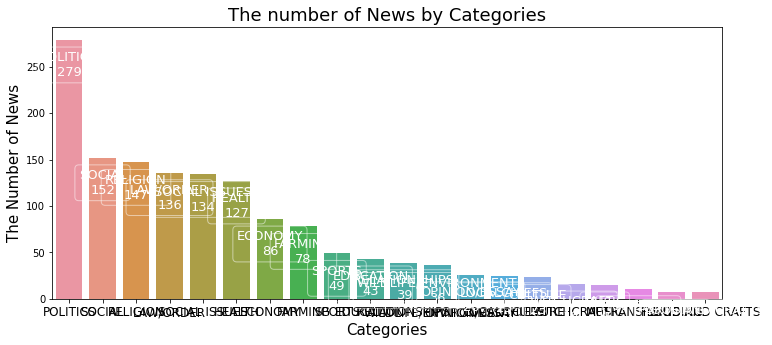

In [16]:
category_counts = df['Label'].value_counts()
categories = category_counts.index

fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(111)
sns.barplot(x = category_counts.index , y = category_counts)
for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )
plt.xlabel('Categories', size = 15)
plt.ylabel('The Number of News', size= 15)
plt.xticks(size = 12)

plt.title("The number of News by Categories" , size = 18)
plt.show()

In [17]:
df_test_2

,ID,Text
0,ID_ADHEtjTi,Abambo odzikhweza akuchuluka Kafukufuku wa ap...
1,ID_AHfJktdQ,Ambuye Ziyaye Ayamikira Aphunzitsi a Tilitonse...
2,ID_AUJIHpZr,Anatcheleza: Akundiopseza a gogo wanga Akundi...
3,ID_AUKYBbIM,Ulova wafika posauzana Adatenga digiri ya uph...
4,ID_AZnsVPEi,"Dzombe kukoma, koma Kuyambira makedzana, pant..."
...,...,...
615,ID_zdpOUWyJ,Kanyongolo Wapempha Oyimira Milandu Kuti Atsat...
616,ID_zhnOomuu,"Amandimenya\nZikomo gogo,\nNdine mtsikana wa z..."
617,ID_zmWHvBJb,Apolisi athotha gulu la MYP Asilikali 56 a gu...
618,ID_zphjdFIb,Mwambo wa ukwati wa Chitonga Mtundu wina uliw...


# Cleaning the texts
* This dataset doesn't require a lot of cleaning because it has written by editor of BBC. There are not links special characters or emojis.
* If we work with twitter text, it needs lot of cleaning.
* Just two different condition added for cleaning. First is punctuation and second is stopwords.
* Punctuation is helping to split the special characters from the words. For example " $15bn " is becoming " 15 bn ". It is not necessary for Glove because it deletes all of them. Howevet, Bert needs them. Seperating punctuations is not compulsory for Bert because it is intelligent to seperate them, but not always, so we will do that to improve model. 

In [18]:
def clean(text, punctuation = False, stopword = False):
    # filter to allow only alphabets
#    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    # Deleting Stopwords
    if stopword == True:
        text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
        text = text.split()
        text = [word for word in text if word not in stopw]
        text = " ".join(text)
    # Seperating the punctuations to tokenize them
    if punctuation == True:
        punc = '@#!?+&*[]-%.:/();$£=><|{}^'
        for p in punc:
            text = text.replace(p, f' {p} ')    

    # Urls
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text)
    text = re.sub(r"  ", " ", text)
    text = re.sub(r"   ", " ", text)
    return text
      

In [19]:
df['cleaned_from_stopw'] = df['Text'].apply(lambda x : clean(x, stopword = True))
df['cleaned'] = df["Text"].apply(lambda x : clean(x,punctuation = True))
df["count"] = df["cleaned"].apply(lambda x: len(x.split()))

df_test_2['cleaned_from_stopw'] = df_test_2['Text'].apply(lambda x : clean(x, stopword = True))
df_test_2['cleaned'] = df_test_2["Text"].apply(lambda x : clean(x,punctuation = True))
df_test_2["count"] = df_test_2["cleaned"].apply(lambda x: len(x.split()))

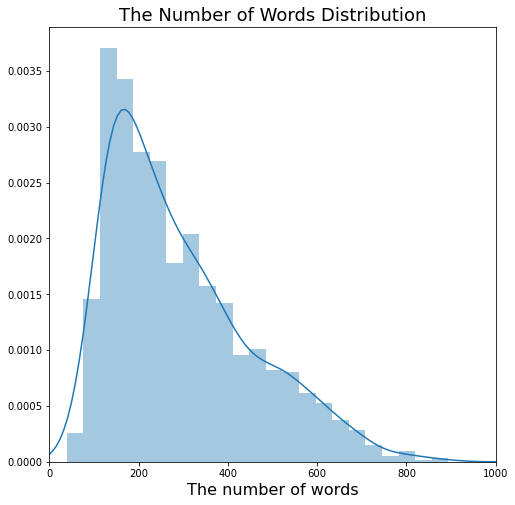

In [20]:
plt.figure(figsize = (8,8))
sns.distplot(df['count'] )
plt.xlim(0,1000)
plt.xlabel('The number of words', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

In [21]:
# df_test_2

* The last 64 texts are splitted for test unseen data.

In [22]:
df =df.iloc[:-124,:].reset_index(drop= True)
df_test = df.iloc[-124:,:].reset_index(drop= True)

# N-Grams
* This function returns the unique words(bigram) or sequence of words and its occurrence frequency.

In [23]:
def create_n_gram(df, category= '',text_column = 'cleaned_from_stopw' ,n_gram = 1):
    n_gram_dict = {}
    if category != '':                                              # This condition is created in case of filtering the label.
        df = df[df['Label'] == category]

    for k in tqdm(df['cleaned_from_stopw']):

        for i in range(len(k)):
            words = k.split()[i:i+n_gram]
            words = " ".join(words)
            
            if (len(words.split()) % n_gram) > 0 or words == '' :       # This condition is created to drop last words of text.  
                continue
            elif words in n_gram_dict.keys():                           
                n_gram_dict[words] +=1
            else:                                                      # We add new word into dictionary. If the word is already in the dictionary, it adds 1 in values.
                n_gram_dict[words] =1

    results = pd.DataFrame.from_dict([n_gram_dict]).T.reset_index()
    results.columns = [category+'_n_grams',category+ '_counts']

    return results

In [24]:
all_words = create_n_gram(df)
print("There are {} unique words in the dataset.".format(len(all_words)))

100%|██████████████████████████████████████████████████████████████████████████████| 1312/1312 [00:38<00:00, 34.37it/s]


There are 47098 unique words in the dataset.


# Bigram, 2-Gram, and 3-Gram
* The new dataframe is created to find top 30 sequence of words in terms of categories.

In [25]:
n_gram_dict = {}
for class_name in class_name_tokenizers.keys():
    for i in range(1,4):
        temp_result =create_n_gram(df,category = class_name, n_gram = i)
        temp_result = temp_result.sort_values(by = class_name + "_counts", ascending = False).head(30).reset_index(drop = True)
        temp_result.columns = [class_name + '_n_grams'+ str(i),class_name + '_counts_'+str(i)]
        n_gram_dict[class_name + str(i)] = temp_result
np_result = np.ones((30,1))
n_gram_result = pd.DataFrame(np_result)
n_gram_result.drop(columns = [0], inplace= True)
for key in n_gram_dict.keys():
    n_gram_result = n_gram_result.join(n_gram_dict[key])

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 22.98it/s]


# Business N-grams

In [26]:
# n_gram_result.iloc[:,:6]
# import pickle
# import gc
# gc.collect()
# favorite_color = { "lion": "yellow", "kitty": "red" }
# file1=open('../Vectors/glove.840B.300d.txt','r')
# pickle.dump(file1.read(), open( "..Vectors/glove.840B.300d.pkl", "wb" ) )
# n_gram_result
# stopw


In [27]:
#  file1

# Entertainment N-grams

In [28]:
n_gram_result.iloc[:,6:12]

,CULTURE_n_grams1,CULTURE_counts_1,CULTURE_n_grams2,CULTURE_counts_2,CULTURE_n_grams3,CULTURE_counts_3
0,mwambo,42,kalonga gawa,21,kalonga gawa undi,20
1,mfumu,41,gawa undi,20,chakwera akwanitse malonjezohrdc,18
2,mafumu,38,akwanitse malonjezohrdc,18,chigwa malonjezo kuoneka,9
3,munthu,35,chakwera akwanitse,18,autsa mapiri chigwa,9
4,amayi,30,nkumangidwanso sipakala,9,nkumangidwanso sipakala waimitsa,9
5,kalonga,28,autsa mapiri,9,sipakala waimitsa chakwera,9
6,adati,27,nduna autsa,9,chisale watuluka nkumangidwanso,9
7,wina,26,mapiri chigwa,9,mapiri chigwa malonjezo,9
8,ana,26,chigwa malonjezo,9,watuluka nkumangidwanso sipakala,9
9,zaka,24,malonjezo kuoneka,9,nduna autsa mapiri,9


# Politics N-grams

In [29]:
n_gram_result.iloc[:,12:18]

,ECONOMY_n_grams1,ECONOMY_counts_1,ECONOMY_n_grams2,ECONOMY_counts_2,ECONOMY_n_grams3,ECONOMY_counts_3
0,boma,201,chakwera akwanitse,42,chakwera akwanitse malonjezohrdc,42
1,adati,167,akwanitse malonjezohrdc,42,chisale watuluka nkumangidwanso,24
2,adatero,166,mkulu bungwe,30,watuluka nkumangidwanso sipakala,24
3,k,124,chisale watuluka,24,nkumangidwanso sipakala waimitsa,24
4,magetsi,111,watuluka nkumangidwanso,24,malonjezohrdc masankhidwe nduna,23
5,bungwe,107,nkumangidwanso sipakala,24,akwanitse malonjezohrdc masankhidwe,23
6,wati,103,sipakala waimitsa,24,chigwa malonjezo kuoneka,23
7,fodya,98,malonjezohrdc masankhidwe,23,masankhidwe nduna autsa,23
8,malawi,97,masankhidwe nduna,23,nduna autsa mapiri,23
9,madzi,86,malonjezo kuoneka,23,autsa mapiri chigwa,23


# Sport N-grams

In [30]:
n_gram_result.iloc[:,18:24]

,EDUCATION_n_grams1,EDUCATION_counts_1,EDUCATION_n_grams2,EDUCATION_counts_2,EDUCATION_n_grams3,EDUCATION_counts_3
0,sukulu,112,secondary school,19,secondary school of,9
1,maphunziro,82,sukulu ukachenjede,17,chakwera akwanitse malonjezohrdc,7
2,mayeso,82,unduna zamaphunziro,13,certificate of education,6
3,ana,74,kaamba koti,10,radio maria malawi,6
4,ophunzira,72,ana ambiri,9,anatchereza tidakumana sukulu,5
5,boma,62,school of,9,wenela pasintha zedi,5
6,adati,40,mpingo katolika,9,pasintha zedi anatchereza,5
7,ambiri,36,kulemba mayeso,8,pvt secondary school,5
8,of,34,of education,8,zedi anatchereza tidakumana,5
9,unduna,31,mayeso jce,8,tidakumana sukulu chiradzulu,5


# Tech N-grams

In [31]:
n_gram_result.iloc[:,24:30]

,FARMING_n_grams1,FARMING_counts_1,FARMING_n_grams2,FARMING_counts_2,FARMING_n_grams3,FARMING_counts_3
0,alimi,345,wenela pasintha,45,wenela pasintha zedi,45
1,mbewu,210,pasintha zedi,45,tidakumana sukulu chiradzulu,41
2,adati,191,tidakumana sukulu,41,anatchereza tidakumana sukulu,41
3,ulimi,162,anatchereza tidakumana,41,zedi anatchereza tidakumana,41
4,adatero,138,zedi anatchereza,41,pasintha zedi anatchereza,41
5,fodya,129,sukulu chiradzulu,41,chakwera akwanitse malonjezohrdc,16
6,madzi,108,alimi ambiri,29,nkumangidwanso sipakala waimitsa,14
7,ngombe,107,ngombe zamkaka,17,watuluka nkumangidwanso sipakala,14
8,mlimi,106,adati alimi,17,chisale watuluka nkumangidwanso,14
9,mvula,95,zotsika mtengo,16,sipakala waimitsa chakwera,10


# Glove Embedding - Tensorflow

In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [33]:
glove_embeddings = np.load('../Vectors/glove.840B.300d.pkl', allow_pickle=True)
print("There are {} words and {} dimensions in Glove Dictionary. And, the number of dimenson is {}. I used the word 'sister' as an example".format(len(glove_embeddings.keys()),len(glove_embeddings['sister']),len(glove_embeddings['sister'])))


There are 2196008 words and 300 dimensions in Glove Dictionary. And, the number of dimenson is 300. I used the word 'sister' as an example


* We will find the words that Glove doesn't include and proportion of uncovered words.
* As you can see from the below table, most common uncovered words are the celebrities, politician and athletes.

In [34]:
count = 0
uncovered_words = {}
covered_words = {}
embedding_matrix = {}
for text in df.cleaned:
    text = text.split()
    for word in text:
        
        if word not in glove_embeddings.keys():
            count += 1
            if word not in uncovered_words:
                uncovered_words[word] = 1
            else:
                uncovered_words[word] += 1
        
        else:
            if word not in covered_words:
                covered_words[word] = 1
            else:
                covered_words[word] += 1
print("---There are {} words in the whole dataset, and {:.2f}% of the words aren't covered by Glove---".format((len(uncovered_words) + len(covered_words)),len(uncovered_words) / (len(uncovered_words)+len(covered_words))*100))
print('---Top 20 most commong uncovered words---')
print(pd.DataFrame([uncovered_words]).T.reset_index().sort_values(by = 0, ascending = False).head(20))

---There are 47340 words in the whole dataset, and 89.65% of the words aren't covered by Glove---
---Top 20 most commong uncovered words---
        index     0
101     anthu  3870
49      ndipo  3371
109   ntchito  2259
19   chifukwa  2035
178      omwe  2010
74    komanso  1951
253     adati  1931
251   adatero  1689
86      zomwe  1647
508     ngati  1603
386     dziko  1311
120     amene  1241
458    mdziko  1108
855     ndiye  1034
138    bungwe   990
37   malamulo   980
327     pomwe   944
26      yemwe   909
188     bwino   909
20     nthawi   888


* We tokenize all off the words from cleaned dataset.
* We use oov_token argument for unkown words like above.
* As you can see from below, we used cleaned data, but this doesn't matter for keras tokenizer because the tokenizer delete all special character. Cleaned data helps to improve the model in Bert. 

In [35]:
df['cleaned'][0]

'mwangonde khansala wachinyamata akamati achinyamata ndi atsogoleri a mawa ambiri amaganiza kuti izi ndi nkhambakamwa chabe koma achinyamata ena monga lusubilo mwangonde akukwaniritsa akupherezetsa mawuwa osati pongolota kuti adzakhala koma kutsogolera kumene chifukwa nthawi yawo yakwana dailes banda adacheza ndi mwangonde khansala wachinyama yemwe akuimira jumbo ward mumzinda wa mzuzu motere chisale watuluka nkumangidwanso sipakala waimitsa nyumba ya malamulo pa wenela pasintha zedi ali ndi masomphenya mwangonde tikudziweni ndine lusubilo mwangonde ndili ndi zaka zakubadwa ndinabadwa mbanja la ana asanu ndipo ndine wachinayi kubadwa ndimachokera mmudzi mwa mwamalopa kwa paramount chief kyungu mboma la karonga sindili pabanja pakadalipano mbiri ya maphunziro anu ndi yotani maphunziro anga a pulaimale ndidachitira kusukula yapulaiveti ya viphya mumzinda wa mzuzu ndipo asekondale ndidachitira pa phwezi boys mboma la rumphi ndili ndi diploma ya accounting ndipo pakadalipano ndikupanga dig

In [36]:
tokenizer_keras = Tokenizer(num_words = 58633, oov_token = "<OOV>")
tokenizer_keras.fit_on_texts(df['cleaned'])
word_index = tokenizer_keras.word_index                # After tokenization, we get all the words and characters in the dataset. 
vocab_size_keras = len(word_index)
embedding_dim = len(glove_embeddings['the'] )          # All of words in glove have same dimmensions(300), so we choose one example "the".
list(word_index.items())[0:10]

[('<OOV>', 1),
 ('ndi', 2),
 ('kuti', 3),
 ('wa', 4),
 ('a', 5),
 ('ya', 6),
 ('pa', 7),
 ('la', 8),
 ('anthu', 9),
 ('ku', 10)]

In [37]:
tokenizer_keras = Tokenizer(num_words = 58633, oov_token = "<OOV>")
tokenizer_keras.fit_on_texts(df['Text'])
word_index = tokenizer_keras.word_index                # After tokenization, we get all the words and characters in the dataset. 
vocab_size_keras = len(word_index)


# Creating embedding matrix for all words in dataset
embedding_matrix = np.zeros((vocab_size_keras+1,embedding_dim))       # We added 1 to vocab size because tokenizer starts with 1, so 0th is not gonna used
for word, i in word_index.items():
    if word in glove_embeddings.keys():
        embedding_vector = glove_embeddings[word]
        embedding_matrix[i] = embedding_vector

* Creating embedding matrix dataframe to show.

In [38]:
tokenized = pd.DataFrame([word_index]).T.reset_index()
tokenized.columns = ['words','index']
temp_emd_matrix = pd.DataFrame(embedding_matrix).reset_index()
temp_emd_matrix = temp_emd_matrix.drop(0, axis = 0)
df_embedding_matrix = pd.merge(tokenized, temp_emd_matrix, on = 'index')
df_embedding_matrix.rename(columns = {"index": "tokens"})
df_embedding_matrix

,words,index,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,<OOV>,1,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,...,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
1,ndi,2,0.340730,-0.351280,-0.14659,-0.24805,0.40504,0.807990,0.205040,-0.20638,...,0.43461,-0.042679,-0.52992,-0.06116,0.504020,-0.121020,-0.097313,0.68939,-0.483970,0.42099
2,kuti,3,0.595010,-0.050506,0.53439,0.16162,-0.15594,0.362390,-0.005318,-0.11768,...,0.44732,-0.282190,0.11333,0.21746,0.446900,0.218490,-0.333440,0.92430,0.554440,-0.59108
3,wa,4,-0.213850,-0.241040,-0.15033,-0.61320,0.68349,-0.078502,0.299000,0.40577,...,0.42027,-0.194520,-0.65114,0.39572,1.118200,-0.885650,0.408950,-0.21102,-0.055937,0.21134
4,a,5,0.043798,0.024779,-0.20937,0.49745,0.36019,-0.375030,-0.052078,-0.60555,...,-0.10347,0.003363,0.21760,-0.20409,0.092415,0.080421,-0.061246,-0.30099,-0.145840,0.28188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47330,lisaphwanye,47331,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,...,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
47331,wokondwerera,47332,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,...,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
47332,zikhudze,47333,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,...,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
47333,imasanduka,47334,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,...,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000


* Labels is converted into binary vector. All of the models use these labels.

In [39]:
def prepare_data(df,tokenizer, max_len= 64):
    sequences = tokenizer.texts_to_sequences(df['cleaned'])
    padded = pad_sequences(sequences, maxlen = max_len, padding = 'post', truncating = 'post')
    labels = tf.keras.utils.to_categorical(df['label'])
    return padded, labels

In [40]:
padded, labels = prepare_data(df_test,tokenizer_keras, max_len = 512)

* Splitting the dataset into training and validation.

In [41]:
training_portion =0.8
training_size = int(len(df) * training_portion)
padded_training = padded[:training_size]
labels_training = labels[:training_size]
padded_val = padded[training_size:]
labels_val = labels[training_size:]

In [42]:
max_len = 512
from keras import backend as K 

# Do some code, e.g. train and save model

K.clear_session()
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

model_glove = tf.keras.Sequential()
model_glove.add(tf.keras.layers.Embedding( vocab_size_keras+1,embedding_dim, input_length = max_len, weights = [embedding_matrix], trainable = False))
model_glove.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences = True)))
model_glove.add(tf.keras.layers.Dropout(0.5))
model_glove.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model_glove.add(tf.keras.layers.Dropout(0.5))
model_glove.add(tf.keras.layers.Dense(128, activation = 'relu'))
model_glove.add( tf.keras.layers.Dense(20 , activation = 'softmax'))

model_glove.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
model_glove.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 512, 300)          14200800  
_________________________________________________________________
bidirectional (Bidirectional (None, 512, 512)          1140736   
_________________________________________________________________
dropout (Dropout)            (None, 512, 512)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               295424    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2

In [43]:
history = model_glove.fit(padded_training,labels_training,epochs= 2, verbose =1 , validation_data = (padded_val, labels_val))

Epoch 1/2
4/4 [==============================] - 48s 12s/step - loss: 2.9513 - accuracy: 0.1290
Epoch 2/2
4/4 [==============================] - 44s 11s/step - loss: 2.7676 - accuracy: 0.1694


* Glove model test data pediction

In [44]:
test_data, test_label = prepare_data(df_test,tokenizer_keras, max_len = 512)
test_prediction = model_glove.predict(test_data)

output_flat = np.argmax(test_label, axis=1).flatten()
prediction_flat = np.argmax(test_prediction, axis=1).flatten()
test_accuracy = np.sum(prediction_flat == output_flat) / len(output_flat)
print("The test set includes {} texts and the accuracy is {}".format(len(output_flat), test_accuracy))

The test set includes 124 texts and the accuracy is 0.21774193548387097


In [45]:
# train_prediction = model_glove.predict(padded_training)

# output_flat = np.argmax(test_label, axis=1).flatten()
# (train_prediction.max(axis=1)>0.9).sum()

In [46]:
# This is for tensorflow
from numba import cuda 
# device = cuda.get_current_device()
# device.reset()
# This is for pytorch
# torch.cuda.empty_cache()

# Bert - Pytorch
* If you usually use tensorflow like me, pytorch is a little bit complicated but it has more comprehensive. We will basically build network from strach.
* Glove is vector representation of words, but Bert is pre-trained model and it need special tokenization. There are three special token sequences for each text input.
* Input vectors are input_ids, attention_masks and token_type_ids.
* Input_ids ---> [[CLS] + sentence tokens + [SEP] + 0 0 0] ---> [101 + sentence tokens + 102 + 0 0 0 0]. You can see below. We add 0 end of the vector based on max length.
* For example, if the sentence is 'I like ice cream' and max length is 10. ---> input_ids: [101, token, token, token, token, 102, 0, 0, 0, 0 ]
* attention_masks vector contains information about masked tokens. 1 is for not masked and 0 for masked. 
* token_type_ids, we actually don't need token type ids because our model is for classification, so we will assign 0 for this vector. If you build bert model answer the questions you will need it. So, I have created argument to use the token_type_ids or not for future projects.

* I have also created two function to create these tokens both function give same results. I just want to show how to create the token from strach and with tokenizer method. Second is easier. 



In [47]:
print(tokenizer.encode(df.cleaned[7], max_length = 128 ) + [0] * 128)    # This is example of input_ids token and max length is 256

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[101, 2089, 2072, 11333, 9067, 29067, 20704, 7068, 5831, 2094, 4213, 13970, 18411, 14841, 8322, 16137, 3286, 3676, 11333, 23564, 2912, 17712, 2819, 3567, 17359, 20391, 11333, 2094, 4143, 5643, 3490, 13970, 3775, 13442, 13629, 17712, 26230, 24454, 2050, 12943, 9148, 3089, 2890, 1050, 3527, 3527, 6369, 23692, 2638, 15775, 11263, 11263, 4328, 11201, 12849, 2863, 15775, 7382, 10264, 2072, 10556, 11837, 2050, 15775, 3654, 2850, 9587, 7677, 11333, 20492, 10497, 7869, 28194, 3270, 17712, 21823, 4205, 6279, 5886, 2050, 24529, 22844, 4135, 2697, 16137, 3286, 3676, 13970, 2213, 3567, 17359, 20391, 28919, 10513, 11201, 6448, 13808, 17712, 21823, 1045, 5831, 8525, 1062, 18622, 16480, 12680, 2072, 9610, 11263, 2243, 4213, 15775, 21451, 8840, 2213, 8545, 13451, 2072, 6643, 11735, 3527, 2697, 2474, 13970, 2386, 3900, 8840, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

# Pytorch steps
* Process data ---> process_dataset ---> data_data_loader ---> News_model(Bert_layer) ---> train_model ---> Results

In [48]:
class process_dataset:
    '''
    This class is created to to prepare the dataset for data loader.
    Bert needs 3 token vecors, so processing_data function or processing_data_encode_plus function will prepare these tokens. Both returns same vectors. Both can be used.
    This getitem method returns data dictionary that includes tokens and labels.
    Labels are encoded to 5 dimensions vectors.
    
    '''
    def __init__(self, df, token_ids_with_label,  max_len, tokenizer, text_column , label_column):
        self.df = df
        self.text = self.df[text_column]
        self.label = self.df[label_column]
       # self.encoded_label = self.df['label']
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.token_ids_with_label = token_ids_with_label
    def __len__(self):
        return len(self.df)
    def __getitem__(self,index):
        
        row = self.text[index]
        row_label = self.label[index]
        convert_token_ids = self.token_ids_with_label
        input_ids, attention_masks, token_type_ids, label = processing_data(row, row_label, self.max_len, convert_token_ids)

        y =torch.LongTensor(label)

        emb = nn.Embedding(20, len(y))
        emb.weight.data = torch.eye(20)
        label_one_hot = emb(torch.LongTensor(y))
        
        data = {
            'input_ids' : torch.tensor(input_ids),
            'attention_masks' : torch.tensor(attention_masks),
            'token_type_ids' : torch.tensor(token_type_ids),
            'labels' : label_one_hot
        }
        
        return data
    
def processing_data( row, row_label, max_len, convert_token_ids = False):
    if convert_token_ids == False:

        label = [class_name_tokenizers[row_label][1]]
    
        temp_input_ids = tokenizer.encode(row, max_length = max_len)

        pad_len = max_len - len(temp_input_ids)  

        input_ids =temp_input_ids + [0] * pad_len

        attention_masks= [1] * len(temp_input_ids)+ [0] * pad_len

        token_type_ids =  [0] * max_len
        
        return np.array(input_ids), np.array(attention_masks), np.array(token_type_ids), np.array(label)

    else:     
        
        
        label_token = tokenizer.encode(row_label)
        
        label = [class_name_tokenizers[row_label][1]]

        max_len = max_len - (len(label_token)-1)

        temp_input_ids = tokenizer.encode(row, max_length = max_len)

        pad_len = max_len - len(temp_input_ids) 

        input_ids = label_token  + temp_input_ids[1:] + [0] * pad_len                                    

        attention_masks= [1] *len(label_token) + [1] * len(temp_input_ids[1:]) + [0] * pad_len

        token_type_ids = [0] *len(label_token) + [1] * len(temp_input_ids[1:])+  [0] * pad_len

        return np.array(input_ids), np.array(attention_masks), np.array(token_type_ids), np.array([label])

# Second way to create input_ids, attention_masks, and token_type_ids

def processing_data_encode_plus(df_text, df_label, max_len , convert_token_ids = False):

    input_ids= []
    attention_masks = []
    token_type_ids = []
    if convert_token_ids == False:

        encoded = tokenizer.encode_plus(df_text,                                   
                                   add_special_tokens = True,
                                   max_length = max_len,
                                   pad_to_max_length = True,
                                   return_token_type_ids = True,
                                   return_attention_mask = True
                                   )
        input_ids = encoded['input_ids']
        attention_masks = encoded['attention_mask']
        token_type_ids = encoded['token_type_ids']
        
        label = tokenizer.encode(df_label)[1]

        return input_ids,attention_masks, token_type_ids, label
    
    else:

        encoded = tokenizer.encode_plus(df_label,
                                    df_text,                                   
                                   add_special_tokens = True,
                                   max_length = max_len,
                                   pad_to_max_length = True,
                                   return_token_type_ids = True,
                                   return_attention_mask = True
                                   )
        input_ids = encoded['input_ids']
        attention_masks = encoded['attention_mask']
        token_type_ids = encoded['token_type_ids']
        
        label = tokenizer.encode(df_label)[1]
        
        return input_ids,attention_masks, token_type_ids, label

In [49]:
# df["input_ids"],df["attention_masks"], df['token_type_ids'],  df['label']= map(list, zip(*df[['Text', 'Label']].apply(lambda x: processing_data(x.Text, x.Label,convert_token_ids = False, max_len = 512), axis = 1)))

# df["input_ids"],df["attention_masks"], df['token_type_ids'],  df['label']= map(list, zip(*df[['Text', 'Label']].apply(lambda x: processing_data_encode_plus(x.Text, x.Label,convert_token_ids = True, max_len = 512), axis = 1)))


In [50]:
def get_data_loader(df,train_index, val_index,tokenizer, batch_size = 16, max_len = 128, num_workers = 0,text_column = 'Text', label_column = 'Label'):
    df_train = df.iloc[train_index].reset_index(drop= True)
    df_val = df.iloc[val_index].reset_index(drop= True)
    train_loader = torch.utils.data.DataLoader(process_dataset(df_train, tokenizer = tokenizer, token_ids_with_label = False, max_len = max_len, text_column = text_column, label_column = label_column),
                                        batch_size = batch_size,
                                        shuffle = False,
                                        drop_last=True,
                                          pin_memory=False,
                                        num_workers = num_workers)
                                              
    
    test_loader = torch.utils.data.DataLoader(process_dataset(df_val, tokenizer = tokenizer, token_ids_with_label = False,max_len = max_len, text_column = text_column, label_column = label_column),
                                             batch_size= batch_size,
                                             shuffle = False,
                                            drop_last=True,
                                              pin_memory=False,
                                             num_workers = num_workers)
    return {'train' : train_loader, "val": test_loader}

def get_test_loader(df,tokenizer, batch_size = 16, max_len = 128, num_workers = 0,text_column = 'Text', label_column = 'Label'):
    
    test_loader = torch.utils.data.DataLoader(process_dataset(df, tokenizer = tokenizer, token_ids_with_label = False, max_len = max_len, text_column = text_column, label_column = label_column),
                                             batch_size = batch_size,
                                             shuffle = False,
                                             num_workers = num_workers)
    return test_loader

* The picutes below shows that the output of Bert Layer (last_hidden_states).
* In the pictures, there are 2000 sentences and max length is 66. (We have 2225 news(64 batch size) and max length is 128).
* Actually, every sentence's shape is 66x768, but we are selecting only fist value of each feature(there are 768). It represents whole sentence.
* Hence, the input of classifier is 768 features and output is 5 category labels.

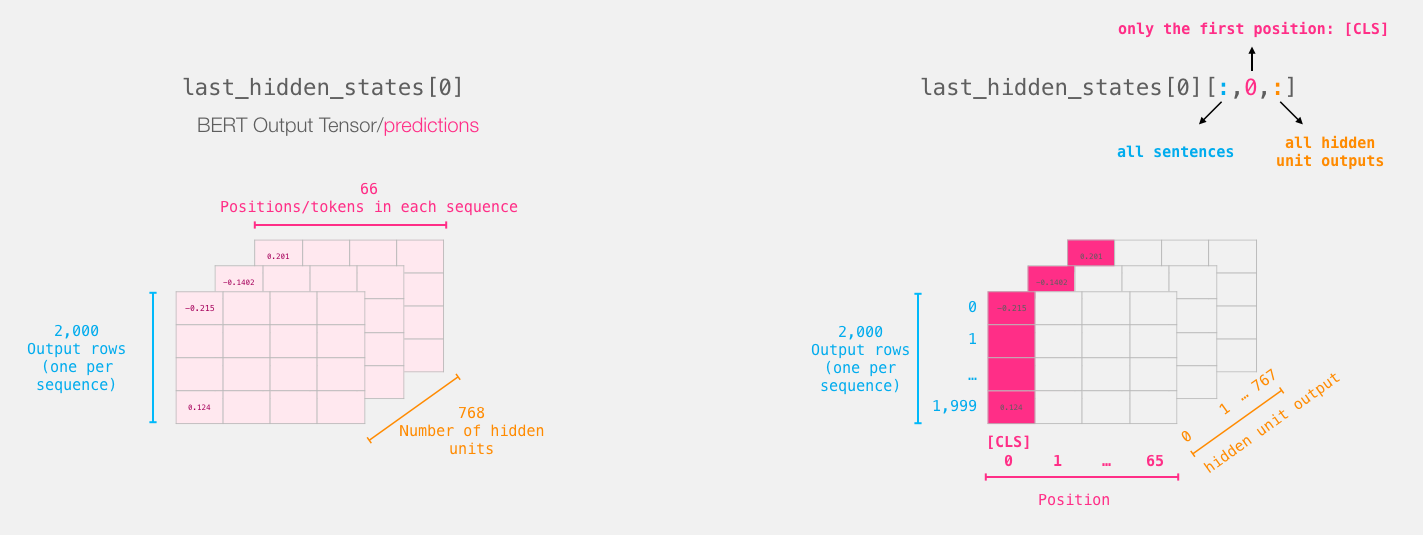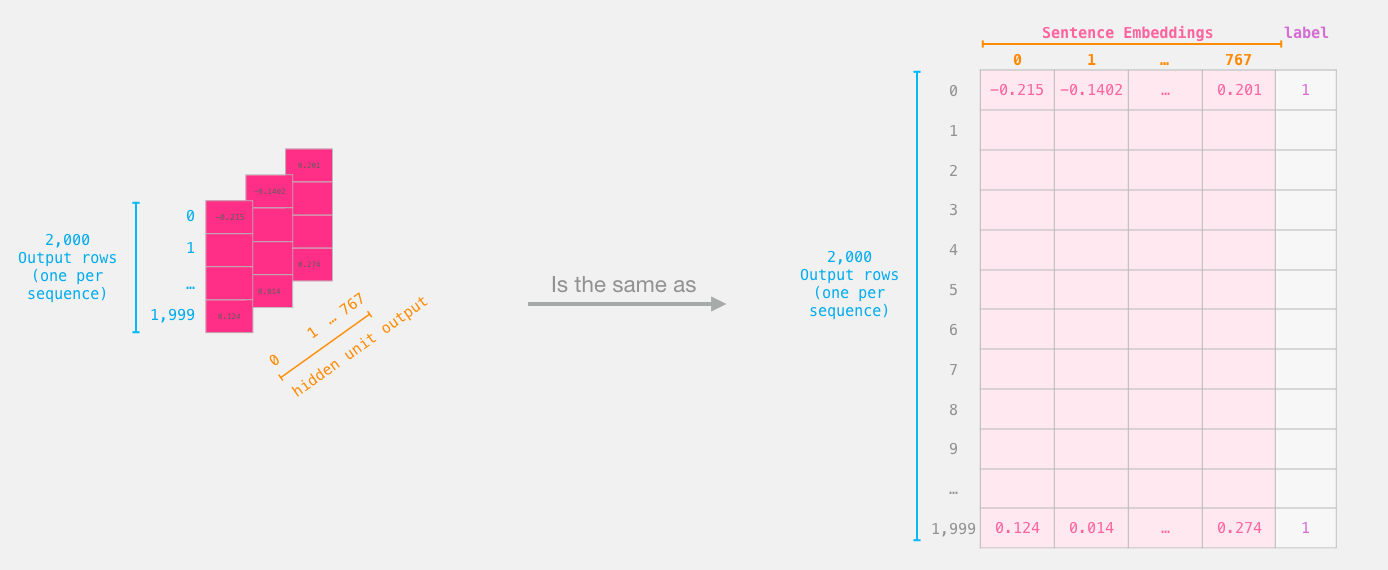

In [51]:
class NewsModel(nn.Module):
    def __init__(self):
        super(NewsModel, self).__init__()
        conf = transformers.BertConfig()
        conf.output_hidden_states = True
        self.model = transformers.BertModel.from_pretrained('bert-base-uncased', config = conf)
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(conf.hidden_size, 20)
        nn.init.xavier_normal_(self.classifier.weight)
    def forward(self, input_ids, attention_masks , token_type_ids):
        out = self.model(input_ids,attention_masks, token_type_ids)
        last_hidden_state_cls = out[0][:,0,:]                                 # This is the output of bert layer like pictures

        output = self.dropout(last_hidden_state_cls)
            
        logits = self.classifier(output)
                
        return logits
            

In [52]:
def loss_fn(output, predicted ):
    ce_loss = nn.BCEWithLogitsLoss()
    loss = ce_loss(output, predicted)
    return loss

In [53]:
def flat_accuracy(output, prediction):
    prediction_flat = np.argmax(prediction, axis=1).flatten()
    output_flat = np.argmax(output, axis=1).flatten()
    return np.sum(prediction_flat == output_flat) / len(output_flat)

In [54]:
def train_model(model, data_loaders, criterion, optimizer, num_epochs, device, flat_accuracy):

    for epoch in range(num_epochs):

        for phase in ['train', 'val']:

            if phase == 'train':
                model.train()
            else:
                model.eval()
            losses = []        
            epoch_loss = 0.0
            accuracy = 0.0
            counter = 0.0
            best_accuracy = 0
            dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

            for data in data_loaders[phase]:

                input_ids = data['input_ids'].to(device)
                attention_masks = data['attention_masks'].to(device)
                token_type_ids = data['token_type_ids'].to(device)
                output = data['labels'].to(device, dtype = torch.long)
                

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    



                    prediction = model( input_ids, attention_masks,  token_type_ids)
                    output = torch.max(output.float(), 1)[0]

                    loss = criterion(output,prediction)
                    if phase == 'train':

                        loss.backward()
                        optimizer.step()
                    losses.append(loss.item())

                    prediction = prediction.detach().cpu().numpy()
                    output = output.detach().cpu().numpy()

                    accuracy += flat_accuracy(output, prediction)
                    counter +=1
                    epoch_loss += loss.item() * len(input_ids)
            epoch_loss = epoch_loss /len(data_loaders[phase].dataset)
            epoch_accuracy =accuracy / counter
            if (phase == 'val' and epoch_accuracy > best_accuracy):
                best_model_weights = model.state_dict()
                best_accuracy = epoch_accuracy
            print("Epoch {} - {}- Loss {:.3f} - Accuracy: {:.3f} , number of examples :{}".format(epoch,phase,epoch_loss,epoch_accuracy,len(data_loaders[phase].dataset)))

    return best_model_weights, losses , best_accuracy

In [55]:
data_loaders = get_data_loader(df, range(100),range(100),text_column = 'Text', label_column = 'Label',tokenizer = tokenizer)

* These are the model inputs. It shows first batch from data_loader.

In [56]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
stop_cnt = 0
model = NewsModel()

for i in data_loaders['train']:
    
    output = i['labels']
    print(i["input_ids"])
    print(i["attention_masks"])
    print(i["token_type_ids"])
    prediction = model(i["input_ids"],i["attention_masks"],i["token_type_ids"]) 
    stop_cnt+=1
    if stop_cnt == 1:
        break
        
output = torch.max(output.float(),1)[0]
prediction = prediction.detach().cpu().numpy()
output = output.detach().cpu().numpy()


tensor([[  101, 12464, 23422,  ..., 17231, 11613,   102],
        [  101, 11338,  2361,  ...,  8625, 10556,   102],
        [  101, 21122,  2290,  ..., 13970,  6499,   102],
        ...,
        [  101,  7029, 21558,  ...,  6396, 13159,   102],
        [  101,  9610, 19648,  ...,  2050, 12464,   102],
        [  101,  9875,  2532,  ..., 24112, 11876,   102]], dtype=torch.int32)
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)


RuntimeError: Expected tensor for argument #1 'indices' to have scalar type Long; but got torch.IntTensor instead (while checking arguments for embedding)

* These are the first batch of labels and prediction before training. As you can see the predictions are really bad before training.

In [ ]:
# i['labels']

In [ ]:
print(output)
print(prediction)

* I cleared the cache to prevent cuda overload, but I still cannot use the higher max length or higher batch size. If anyone has solution, please give advice :)

In [ ]:
skf = StratifiedKFold(n_splits = 5, shuffle = True)
best_accuracy = 0
for fold, (train_index, val_index) in enumerate(skf.split(df, df.Label),start = 1):

    print(f"fold :{fold}")
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")
    model = NewsModel()
    model.to(device)
    optimizer = AdamW(model.parameters(), lr = 3e-5)
    data_loaders = get_data_loader(df,train_index, val_index ,tokenizer = tokenizer, batch_size = 64, max_len = 128,text_column = 'cleaned', label_column = 'Label')
    criterion = loss_fn
    

    model_weights, losses, accuracy = train_model(model, data_loaders, criterion, optimizer,flat_accuracy=flat_accuracy, num_epochs = 4, device = device)
    
    if accuracy > best_accuracy:
        final_model_weights = model_weights        # This keeps the best model's weights.
        best_accuracy = accuracy

* The model improved from 96% to 98%. 

In [ ]:
print('The best accuracy of the validation dataset is {:.2f}'.format(best_accuracy*100))

* This function is for prediction from unseen dataset.

In [ ]:
def prediction_class(final_model_weights, text):
    batch_test_losses = []
    batch_test_accuracies = []
    best_test_accuracy = 0
    use_cuda = torch.cuda.is_available()
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    model = NewsModel()

    model.load_state_dict(final_model_weights)
    class_names = pd.DataFrame(class_name_tokenizers).T
    test_data_loaders = get_test_loader(text, tokenizer, batch_size = 1, max_len = 128, num_workers = 0,text_column = 'cleaned', label_column = 'category')
    for i, data in enumerate(test_data_loaders):

        prediction = model(data['input_ids'], data['attention_masks'], data['token_type_ids'])
        output = data["labels"]
        output =torch.max(output.float(),1)[0]

        prediction = prediction.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
#        print(output)
#        print(prediction)
#        print(text.loc[i,'text'])
#        print("Real output is {}, Prediction is :{}\n".format(text.loc[i,'category'], class_names[class_names[1] == np.argmax(output)].index[0]))
        batch_test_accuracy = flat_accuracy(output, prediction)
        batch_test_accuracies.append(batch_test_accuracy)
        test_accuracy = sum(batch_test_accuracies) / len(batch_test_accuracies)
    return print("Test dataset includes {} texts and the test set accuracy is {:.2f}.".format(len(batch_test_accuracies),test_accuracy))

* We saved the weights of best model and use in the prediction class method.
* You can see the accuracy of the test set. It predicted correctly all test set. It is amazing result.

In [ ]:
prediction_class(final_model_weights, df_test)

* Cuda library's empty_cache() method clears the gpu for pytorch, so in next neural network gpu memory is not gonna be overload.

In [ ]:
torch.cuda.empty_cache()

 # Bert - Tensorflow
* Compared to pytorch, tensorflow process is easier. 
* There is another library to load bert_layer for tensorflow. First bert library needs special data type that is converted by pytorch data_loader, so I loaded by tensorflow hub library.


In [57]:
tf.keras.backend.clear_session()
import tensorflow_hub as hub
# !pip install tensorflow_hub

In [58]:
def build_model(max_len = 128):
    ids = tf.keras.layers.Input(shape = (max_len, ), dtype = tf.int32)
    masks = tf.keras.layers.Input(shape =(max_len,), dtype = tf.int32)
    token_ids = tf.keras.layers.Input(shape =(max_len,), dtype = tf.int32)

    bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",  trainable=True)
    pooled_output, sequence_output = bert_layer([ids, masks ,token_ids])

    output = sequence_output[:,0,:]

    out = tf.keras.layers.Dropout(0.5)(output)

    out = tf.keras.layers.Dense(20, activation = 'softmax')(out)

    model = tf.keras.models.Model(inputs = [ids,masks,token_ids], outputs= out)

    optimizer = tf.optimizers.Adam(learning_rate = 3e-5)

    model.compile(loss ='categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

In [59]:
def encode(df, max_len = 128):

    ids = np.zeros((len(df), max_len), dtype = 'float32')
    masks = np.zeros((len(df), max_len), dtype = 'float32')
    token_ids = np.zeros((len(df), max_len), dtype = 'float32')
    labels = np.zeros((len(df), max_len), dtype = 'float32')

    ids, masks, token_ids, labels=map(list, zip(*df[['Text', 'Label']].apply(lambda x: processing_data(x.Text, x.Label,convert_token_ids = False, max_len = max_len), axis = 1)))

    ids = np.array(ids, dtype ='float32')
    masks = np.array(masks, dtype ='float32')
    token_ids = np.array(token_ids, dtype ='float32')
    labels = tf.keras.utils.to_categorical(np.array(labels))
    return ids,masks, token_ids, labels

In [ ]:
skf = StratifiedKFold(n_splits = 4, shuffle = True)

ids, masks, token_ids, labels = encode(df, max_len = 128)

for k , (train_index,val_index) in enumerate(skf.split(ids, labels.argmax(1)), start =1):
    ids_train = ids[train_index,:],
    masks_train = masks[train_index,:]
    token_train = token_ids[train_index,:]
    labels_train = labels[train_index,:]
    ids_val = ids[train_index,:],
    masks_val = masks[train_index,:]
    token_val = token_ids[train_index,:]
    labels_val = labels[train_index,:]
    print("fold :{}".format(k))
    model = build_model()
    history = model.fit((ids_train, masks_train, token_train), labels_train, epochs = 3, verbose = 1, batch_size = 32, validation_data = ((ids_val, masks_val, token_val), labels_val))

* Tensorflow performs better than pytorch. I was expecting similar result, but this result is 2.5% better than pytorch.

In [ ]:
ids_test, masks_test, token_ids_test, labels_test = encode(df_test, max_len = 128)
prediction = model.predict((ids_test, masks_test, token_ids_test))
output = tf.keras.utils.to_categorical(df_test['label'])
test_result = flat_accuracy(output, prediction)
print("The test set includes {} texts and the accuracy is {}".format(len(output), test_result))

# Summary

* This dataset was very clean and there weren't many special characters because these news is written by BBC editors. So, our final accuracy is very high.
* BERT performs almost perfectly in tensorflow model, the validation accuracy is around 99.5%.
* **BERT(Pytorch - Tensorflow) models predicted all 64 unseen News correctly** which is great. However, **in the model with Glove embeddings, test set accuracy was 0.875**.


* PS: I haven't builded many neural networks with PyTorch, so probably, this is the reason of that the accuracy is lower in my Pytorch model than Tensorflow model. Please give me recommendations if you see anything that can improve the model.
* If you like it pelase upvote, thanks.